<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TrainNVP_and_measure_Reconstruction_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
import os
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.contrib.distributions import softplus_inverse
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file as pch

In [13]:
sys.path.append('../')
from vae.model import get_prior, get_posterior, get_likelihood

In [4]:
import vae.create_datasets as crd

In [5]:
likelihood  = 'Gauss'
class_label = 3

In [6]:
params = pkl.load(open('../params/params_%s_%d.pkl'%(likelihood,class_label),'rb'))
module_dir = params['module_dir']
model_dir  = params['model_dir']

In [7]:
all_subdirs   = [os.path.join(module_dir,d) for d in os.listdir(module_dir+'/') if os.path.isdir(os.path.join(module_dir,d))]
latest_subdir = max(all_subdirs, key=os.path.getmtime)

In [14]:
generator_path   = os.path.join(latest_subdir,'decoder')
encoder_path     = os.path.join(latest_subdir,'encoder')
nvp_func_path    = os.path.join(module_dir,'nvp')


In [15]:
if not os.path.exists(nvp_func_path):
    os.makedirs(nvp_func_path)

In [54]:
tf.reset_default_graph()

train_input_fn, eval_input_fn = crd.build_input_fns(params['data_set'], params['batch_size'],label=params['class_label'])

lr            = tf.placeholder_with_default(0.001,shape=[])
sigma         = tf.placeholder_with_default(0.1,shape=[])
sample_size   = tf.placeholder_with_default(16,shape=[])
encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)


prior         = get_prior(params['latent_size'])
posterior     = get_posterior(encoder)
likelihood    = get_likelihood(generator,params['likelihood'],sigma)

# # uncorrupted data

z = posterior(train_input_fn()[0]).mean()

prior_sample = prior.sample(sample_size)

x = likelihood(prior_sample).mean()




# # -----------train NVP ----------------------#

nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]


def get_nvp():
    p1 = np.arange(0,params['latent_size']//2)
    p2 = np.arange(params['latent_size']//2,params['latent_size'])
    perm=np.concatenate((p2,p1))
  
    base_dis = get_prior(params['latent_size'])

  
    chain = []
  
    for i,s in enumerate(nvp_size):
        chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
        chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

    nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
    return nvp

def nvp_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(z_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

nvp_spec  = hub.create_module_spec(nvp_module_spec)

nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)


nvp       = get_nvp()
loss      = -tf.reduce_mean(nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob'])

nvp_sample = nvp_funcs({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':prior_sample}, as_dict=True)['fwd_pass']
x_new = likelihood(nvp_sample).mean()
opt_op_nvp= optimizer.minimize(loss)

# # ---------------------------end train nvp ----------------- #

# #comment train nvp above section above and uncomment this for loading the trained module

# #nvp_funcs     = hub.Module(nvp_func_path, trainable=False)

loading mnist dataset
sigma:0
Tensor("module_1_apply_default/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
Tensor("module_1_apply_default_1/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)


In [55]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Training of the NVP**

In [56]:
nvp_loss = []

In [58]:
ii     = 0
nepoch = 0
learning_rate = 1e-5

#train the nvp
while nepoch<1000:
    _, ll = sess.run([opt_op_nvp,loss],  feed_dict={lr: learning_rate})
    nvp_loss+=[ll]
    if ii%500==0:
        print(ll)
    ii+=1

12.5739155
12.480951
12.964352
12.413986
12.036634
11.84043
12.473368
11.940823


KeyboardInterrupt: 

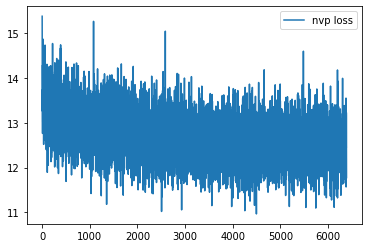

In [59]:
plt.figure()
plot(nvp_loss[::],label='nvp loss')
legend()

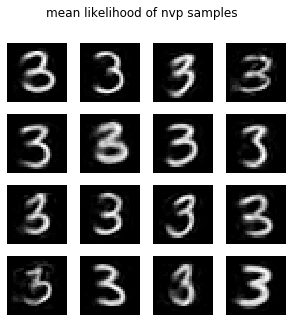

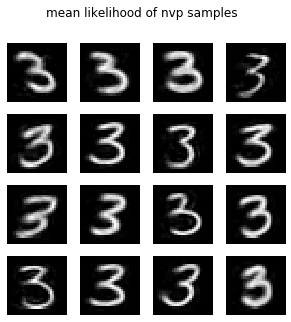

In [64]:
s_nvp       = sess.run(x_new)
s           = sess.run(x)

figure(figsize=(5,5))
suptitle('mean likelihood of nvp samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('mean likelihood of nvp samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s_nvp[i,:],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


In [65]:
nvp_funcs.export(nvp_func_path,sess)